# Assignment 3 (MW, ER, VMP)

## Josh option



### Load packages & data.

In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import math

In [2]:
data = pd.read_csv("HerrmannThoeniGaechterDATA.csv", skiprows=3)

## Preprocessing

### Specify constants

In [3]:
## constants
groupSize = 4
ntrials = 10
pi = 1.4
ntokens = 20
vals = list(range(21)) #possible values to contribute - from 0 to 20 tokens

### Gini data

In [4]:
def get_gini(city):
    if city == "Melbourne":
        return 34.3
    if city == "Minsk":
        return 25.3
    if city == "Chengdu":
        return 38.5
    if city == "Copenhagen":
        return 28.7
    if city == "Bonn":
        return 31.9
    if city == "Athens":
        return 34.4
    if city == "Seoul":
        return 31.6
    if city == "Samara":
        return 37.5
    if city == "Zurich":
        return 32.7
    if city == "St. Gallen":
        return 32.7
    if city == "Istanbul":
        return 41.9
    if city == "Nottingham":
        return 34.8
    if city == "Dnipropetrovs'k":
        return 26.1
    if city == "Boston":
        return 41.1
    
data["gini"] = data["city"].apply(lambda x: get_gini(x))

### Only some of the data is used

In [5]:
redDat = data.iloc[::3, :] #get only every third row, the others are other responses that we don't need

In [6]:
redDat.reset_index(inplace = True, drop = True)

In [7]:
group_names = set(redDat["groupid"])
group_names = sorted(list(group_names))
ngroups = len(group_names)

### DOES SOMETHING FUCKED HERE
subject_names = set(redDat["subjectid"])
nsubjects = len(subject_names)
ngroups = 269

### Punish & no-punish
Note that the "Gc" variable is not used in the actual models (in ours or in Josh's own analysis). 

We think he made some error in computing it (in R) but it does not really matter here, 

since we are not using it in the models..

In [8]:
## No punish initialized
c_no_punish = np.zeros(shape = (groupSize, ntrials, ngroups))
Ga_no_punish = np.zeros(shape = (ntrials, ngroups))
Gc_no_punish = np.zeros(shape = (groupSize, ntrials, ngroups))

#punished initialized
c_punish = np.zeros(shape = (groupSize, ntrials, ngroups))
Ga_punish = np.zeros(shape = (ntrials, ngroups))
Gc_punish = np.zeros(shape = (groupSize, ntrials, ngroups))

#missing vector
missing = np.zeros(shape = (ngroups))

### Missing data handling

In [9]:
for g in range(ngroups):
    ### fancy way of fixing missing data - they will just become 0, 
    # and their position is then logged in "missing"-vector
    try: 
        #no punish
        c_no_punish[:,:,g][0] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "N-experiment")]["senderscontribution"][0:10].values
        c_no_punish[:,:,g][1] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "N-experiment")]["senderscontribution"][10:20].values
        c_no_punish[:,:,g][2] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "N-experiment")]["senderscontribution"][20:30].values
        c_no_punish[:,:,g][3] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "N-experiment")]["senderscontribution"][30:40].values
        
        #punish
        c_punish[:,:,g][0] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "P-experiment")]["senderscontribution"][0:10].values
        c_punish[:,:,g][1] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "P-experiment")]["senderscontribution"][10:20].values
        c_punish[:,:,g][2] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "P-experiment")]["senderscontribution"][20:30].values
        c_punish[:,:,g][3] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "P-experiment")]["senderscontribution"][30:40].values
    
    except: #could be more general... 
        missing[g] = 1
    
    #make "Ga"
    Ga_no_punish[:,g] = c_no_punish[:,:,g].mean(axis=0)
    Ga_punish[:,g] = c_punish[:,:,g].mean(axis=0)
    
    #make "Gc"
    for s in range(groupSize):
        Gc_no_punish[:,:,g][s] = np.delete(c_no_punish[:,:,g], s, 0).sum(axis=0) #just gives a single number though...
        Gc_punish[:,:,g][s] = np.delete(c_punish[:,:,g], s, 0).sum(axis=0)

### Concat the different conditions

In [10]:
c = np.zeros(shape = (groupSize, ntrials, ngroups, 2))
Ga = np.zeros(shape = (ntrials, ngroups, 2))

In [11]:
c[:,:,:,0] = c_no_punish
c[:,:,:,1] = c_punish

Ga[:,:,0] = Ga_no_punish
Ga[:,:,1] = Ga_punish

### Gini Coefficient

In [12]:
Gini = np.zeros(shape = ngroups)
for g in range(ngroups):
    Gini[g] = redDat[(redDat["groupid"] == group_names[g]) & (redDat["p"] == "P-experiment")]["gini"].values.mean()

In [13]:
mask = np.isnan(Gini) == False

In [14]:
Ga_punish = Ga_punish[:,mask]
Ga_no_punish = Ga_no_punish[:,mask]

c = c[:,:,mask,:]
Ga = Ga[:,mask,:]
Gini = Gini[mask]

#get new ngroups
ngroups = len(Gini)

## Part 2: Decay Model

$$c_{g,s,t}^\mu = c^0_{g,s} \cdot e^{-\gamma_{s,g} \cdot t}$$

$$c^0_{g,s} = \beta^c_0 + \beta^c_{Gini} \cdot Gini_g$$

$$\gamma_{s,g} = \beta^\gamma_0 + \beta^\gamma_{Gini} \cdot Gini_g$$

## Variable set-up
We spent a lot of time trying to translate Josh's jags code.

Jags seems to be all about for-looping which we have tried to

avoid. However, there are many things that we have not been 

able to satisfactorily do. 

First we take out only the first (of two) conditions of "c". 

In [15]:
y = c[:,:,:,0]

Then we create three variables: <br/>
* idx_g (269 groups) <br/>
* idx_s (4 subjects) <br/>
* t (10 trials) <br/>

In [16]:
idx_g = np.arange(ngroups)
idx_s = np.array([0,1,2,3])
t = np.arange(ntrials)

We need the time variable "t" in a different format in order to avoid loops -
and make sure that we can multiply properly with other elements. 
Thus we stack, transpose & insert an empty dimension.

In [17]:
t_stack = np.stack((t,t,t,t))
t_stack = t_stack.T
t_stack = t_stack[:, :, None]
t_stack.shape

(10, 4, 1)

Same issue with shape for Gini. 

In [18]:
Gini_stack = np.stack((Gini, Gini, Gini, Gini))
Gini_stack = Gini_stack.T
Gini_stack.shape

(244, 4)

Same issue with shape for idx_s

In [19]:
idx_s = idx_s[:, None]
idx_s.shape

(4, 1)

Josh has shape (4, 10, 244) which corresponds to (subjects, time, groups),

but we found it easier to have (10, 4, 244) which corresponds to (time, subjects, groups). 

Should not make a difference. Just a different order. 

In [20]:
y = np.reshape(y, (10, 4, 244));

### Decay model 

In [21]:
with pm.Model() as m:
    ## priors
    beta0_c0 = pm.HalfNormal("beta0_c0", sigma = 1)
    betaGini_c0 = pm.Normal("betaGini_c0", 0, 1)
    
    beta0_gamma = pm.HalfNormal("beta0_gamma", sigma = 1)
    betaGini_gamma = pm.Normal("betaGini_gamma", 0, 1)
    
    ## group_level
    sigma_c = pm.Gamma("sigma_c", 1, 1, shape = (1, len(idx_s), len(idx_g)))
    
    c_0 = pm.Deterministic("c_0", beta0_c0 + betaGini_c0 * Gini_stack[idx_g, idx_s])
    
    gamma = pm.Deterministic("gamma", beta0_gamma + betaGini_gamma * Gini_stack[idx_g, idx_s])
    
    ## mu. 
    mu_c = c_0 * pm.math.exp(-gamma * t_stack)

    ## likelihood
    y_pred = pm.Normal("y_pred", mu = mu_c, sigma = sigma_c, observed = y)
    
    

### Sample from the model
We cannot sample with "chains = 2". 

We get the error: "ValueError: Mass matrix contains zeros on the diagonal."

Specifically: "The derivative of RV `sigma_c_log__`.ravel()[0] is zero.". 

However, for some reason it works with "chains = 1". 

This seems a bit buggy, but we had to settle for it. 

In [22]:
with m: 
    m_idata = pm.sample(chains = 1, # breaks with 2 chains..
                       return_inferencedata = True,
                       random_seed = 42,
                       tune = 2000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_c, betaGini_gamma, beta0_gamma, betaGini_c0, beta0_c0]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 231 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [23]:
import arviz as az

## Plot trace

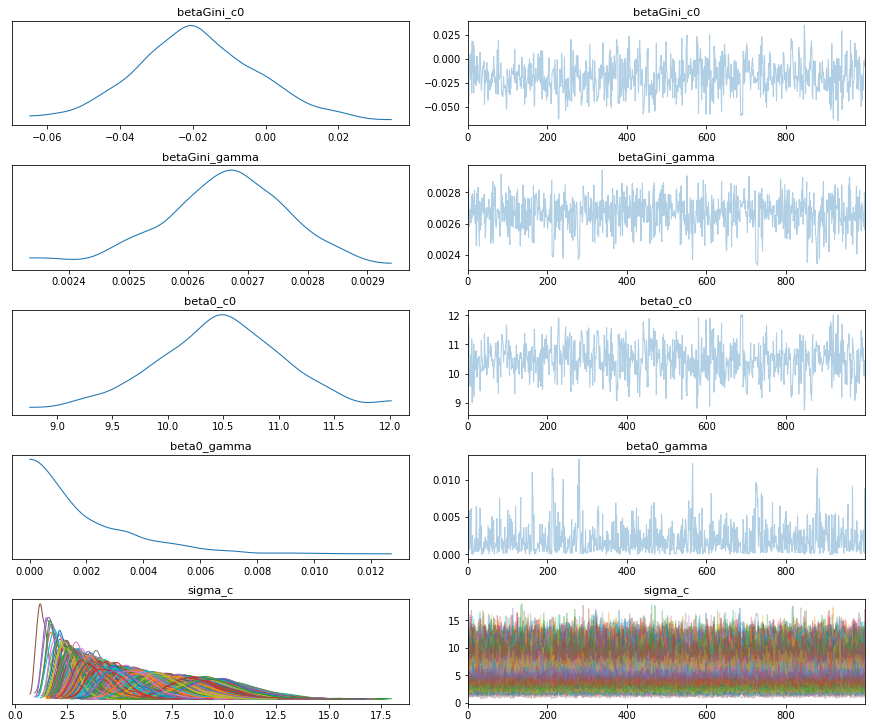

In [24]:
az.plot_trace(m_idata, var_names = ["betaGini_c0",
                                   "betaGini_gamma",
                                   "beta0_c0",
                                   "beta0_gamma",
                                   "sigma_c"]);

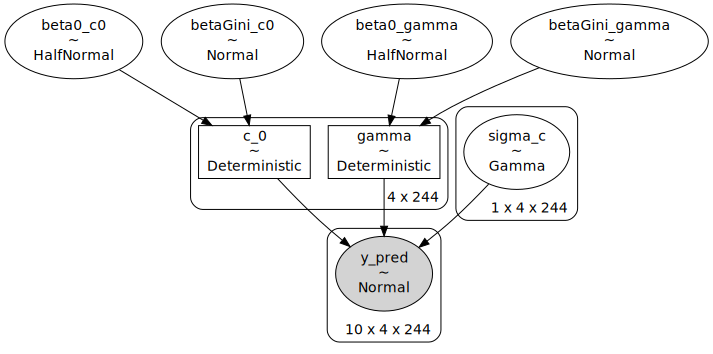

In [25]:
pm.model_to_graphviz(m)

## Posterior predictive

In [26]:
with m: 
    m_post = pm.sample_posterior_predictive(m_idata,
                                           random_seed = 42)

Get index of max and min gini in order to reproduce Josh's plot

of how cooperation declines in highest and lowest gini groups. 

In [27]:
maxs = np.where(Gini == Gini.max())
mins = np.where(Gini == Gini.min())

Pull out mean outcome predictions across samples (axis 0).

In [28]:
y_mean = m_post["y_pred"].mean(axis = 0) # mean over samples
y_mean = y_mean.mean(axis = 1) # mean over participants 
y_mean.shape

(10, 244)

Use the indexes to grab the relevant y predictions. 

In [29]:
y_high = y_mean[:, maxs[0]]
y_low = y_mean[:, mins[0]]

Now average across groups within high and low gini.

In [30]:
y_high_mean = y_high.mean(axis = 1)
y_low_mean = y_low.mean(axis = 1)

In [31]:
import matplotlib.pyplot as plt

Pull out standard deviation to get some confidence around
our predictions. 

In [32]:
y_high_std = y_high.std(axis = 1)
y_low_std = y_high.std(axis = 1)

## Reproducing Josh plot
The plot below closely matches the plot from the Josh paper. 

Groups from high-gini countries show faster declining coopeartion (red line) 

as compared to groups from low-gini countries (blue line). 

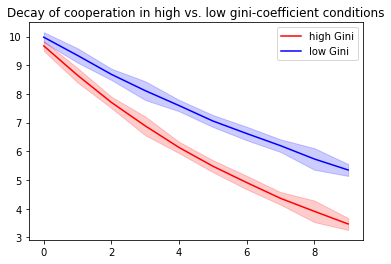

In [33]:
# reproducing Josh w. uncertainty.
std = 3 # 3 standard deviations. 
plt.plot(y_high_mean, color = "r", label = "high Gini")
plt.plot(y_low_mean, color = "b", label = "low Gini")
plt.fill_between(t, y_high_mean - std*y_high_std, y_high_mean + std*y_high_std,
                alpha = 0.2, color = "r")
plt.fill_between(t, y_low_mean - std*y_low_std, y_low_mean + std*y_low_std,
                alpha = 0.2, color = "b")
plt.title("Decay of cooperation in high vs. low gini-coefficient conditions")
plt.legend()
plt.plot();

# Hierarchical model (attempt)

### Preferences:

$$pvec = p_0 + \beta_p \cdot tokenvalues $$

$$p_t = pvec[Gb_t]$$

where Gb_t is the belief of what the other person will do at time T

$$Gb_t = \gamma ( Gb_{t-1}) + (1-\gamma) (G_{a_{t-1}})$$

$$c_t = \omega_t (Gb_t) + (1-\omega_t) (p_t)$$

$$\omega_t = \omega_{t-1}(1-\lambda)$$

### Getting the hierachical model

$$B^P_{g,s} \sim Beta(Shape_{g,s,1}, Shape_{g,s,2})$$

$$Shape_1 = \mu B^P_{g,s} + \sigma_{g,s}$$
$$Shape_2 = (1 - \mu B^P_{g,s}) + \sigma_{g,s}$$

$$Probit(\mu B^P_{g,s}) = \beta_0^P + \beta^P_{Gini} \cdot Gini$$

As we did for the first model we attempted to make this model without looping. 
However, this proved difficult for several reasons. Firstly, there are a lot
of loops in Josh's code. More importantly, we have variables that depend on previous
time-steps. E.g. 
$$ Gb_t = \gamma (Gb_{t-1}) + (1 - \gamma )(G_{a_{t-1}}) $$
This proved tricky, because we attempted to solve it using theano.scan 
which is the theano-way of doing for-loops. We tried a lot of stuff, but eventually
gave up because the integration between pymc3-objects and theano scan is really tricky.
The issue is that theano.scan expects array-like structures, but we need to use "gamma"
which is a parameter we want to infer. 

### set up parameters

In [34]:
# hard-coded parameters
pi = 1.4
ntokens = 20
vals = np.arange(0, 21) # or 1-21

### Create probit function

In [35]:
# https://books.google.dk/books?id=ys8oDwAAQBAJ&pg=PA114&lpg=PA114&dq=probit+transformation+theano&source=bl&ots=uK3a2NXdVY&sig=ACfU3U1zANvv3Kz6qBmu3RAFnMw3cqkPHQ&hl=da&sa=X&ved=2ahUKEwjd4riAoMnwAhUlg_0HHc3vD_gQ6AEwEnoECA8QAw#v=onepage&q=probit%20transformation%20theano&f=false
def probit_phi(x): 
    mu = 0
    sd = 1
    return 0.5 * (1 + tt.erf((x - mu) / sd * tt.sqrt(2)))

### Again we rely on the stacking approach

In [36]:
vals_stack = np.stack((vals, vals, vals, vals)).T
vals_stack = vals_stack[:, :, None]
vals_stack.shape

(21, 4, 1)

### Set up variables

In [37]:
y = c[:,:,:,0]

In [38]:
Ga_first = Ga[:, :, 0]
Ga_first = np.stack([Ga_first, Ga_first, Ga_first, Ga_first])

### Showcasing our problem 

Here we just show a dummy example that we used to test the functionality of theano.scan.

In [39]:
# s = 3
# g = 2
# t = 10

## gamma test 
gamma_test = np.array([[1, 2], [1, 2], [1, 2]])

## Ga test 
Ga_test = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6],
                   [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])

Ga_test = np.stack((Ga_test, Ga_test, Ga_test))

## Gb test 
Gb_test = np.array([[4, 2], [4,2], [4,2]])

In [40]:
# theano config
theano.config.exception_verbosity='high'
theano.config.optimizer='None'
theano.config.compute_test_value="ignore"

# theano variables
s_t = tt.iscalar()
indexing = tt.ivector()
Ga = tt.tensor3()
gamma = tt.dmatrix() 
Gb = tt.dmatrix() 

# the function that we need to update Gb. 
def create_gb(time_step, Gb, Ga, gamma): #gamma_test 
    return (gamma * Gb) + ((1-gamma) * Ga[:, time_step, :])

results, _ = theano.scan(
    fn=create_gb,
    outputs_info= [Gb],
    non_sequences=[Ga, gamma],
    sequences=tt.arange(10))

f = theano.function([Gb, Ga, gamma], results)
y = f(Gb_test, Ga_test, gamma_test)

# append the first element (time = 0). 
Gb_master = np.append([Gb_test], y, axis = 0);

# this is exactly what we need. 
Gb_master

array([[[   4.,    2.],
        [   4.,    2.],
        [   4.,    2.]],

       [[   4.,    2.],
        [   4.,    2.],
        [   4.,    2.]],

       [[   4.,    1.],
        [   4.,    1.],
        [   4.,    1.]],

       [[   4.,   -2.],
        [   4.,   -2.],
        [   4.,   -2.]],

       [[   4.,   -9.],
        [   4.,   -9.],
        [   4.,   -9.]],

       [[   4.,  -24.],
        [   4.,  -24.],
        [   4.,  -24.]],

       [[   4.,  -50.],
        [   4.,  -50.],
        [   4.,  -50.]],

       [[   4., -103.],
        [   4., -103.],
        [   4., -103.]],

       [[   4., -210.],
        [   4., -210.],
        [   4., -210.]],

       [[   4., -425.],
        [   4., -425.],
        [   4., -425.]],

       [[   4., -856.],
        [   4., -856.],
        [   4., -856.]]])

Unfortunately, this approach does not work within the context of what we actually want to do.

The issue is that $ \gamma $ is not a matrix, but rather a pymc3 object. 

This is where we decided to give up. We have spent a lot of time trying to make it work. 

Would really appreciate to see a working pymc3 boot of Josh's code. 

We have not been able to find anything that quite matches his analysis to base this on. 

If you could make a notebook, or point us in a good direction that would be super cool. 

In [41]:
## run model 
with pm.Model() as m1: 
    
    # priors
    beta0_pbeta = pm.Normal("beta0_pbeta", 0,1) 
    betaGini_pbeta = pm.Normal("betaGini_pbeta", 0,1)
    
    mu_pbeta_probit = beta0_pbeta + (betaGini_pbeta*(Gini_stack[idx_g, idx_s]))
    # concentration parameter
    sigma_pbeta = pm.Uniform("sigma_pbeta", 1,100, shape = (len(idx_s), len(idx_g))) 
    
    # reparameterising beta prior for slope of beliefs/preferences  in CC model 
    mu_pbeta = probit_phi(mu_pbeta_probit) # probit descale - - mean for cond is lower than overall
    shape1_pbeta = mu_pbeta * sigma_pbeta
    shape2_pbeta = (1 - mu_pbeta) * sigma_pbeta
    
    ###### model level priors ######
    #initial weighting of beliefs about others contributions in choice of own contribution, relative to prefs
    omega1 = pm.Beta("omega1", 1, 1, shape = (len(idx_s), len(idx_g))) 
    
    #decay rate in weighting of beliefs about others - prefs dominate over time
    lambda1 = pm.Beta("lambda1", 1, 1, shape = (len(idx_s), len(idx_g)))
    
    #parameter weighting of beliefs about what others will contribute, relative to observed contribution
    gamma_first = pm.Beta("gamma_first", 1, 1, shape = (len(idx_s), len(idx_g)))

    #~ dunif(0,20) #intercept of linear model relating preferred contributions to possible contribution values
    p0 = np.zeros(shape = (len(idx_s), len(idx_g))) #??

    #slope of linear model relating preferred contributions to possible contribution values
    pbeta = pm.Beta("pbeta", shape1_pbeta+1, shape2_pbeta+1,
                   shape = (len(idx_s), len(idx_g))) #dbeta(shape1_pbeta[s,g]+1,shape2_pbeta[s,g]+1)
    
    # vals (0-20)
    pvals = p0 + (pbeta * vals_stack) # pvals[s,i,g] <- p0[s,g] + (pbeta[s,g] * vals[i]) 
    
    ######## starting conditions ####### 
    omega = tt.reshape(omega1, (len(idx_s), 1, len(idx_g)))
    Gb_first = c[:, 0, :, 0] 
    mu_c_first = Ga[0, :, 0]
    
    ############# CREATE GB ############
    theano.config.exception_verbosity='high'
    theano.config.optimizer='None'
    theano.config.compute_test_value="ignore"
    s_t = tt.iscalar()
    indexing = tt.ivector()
    Ga_ivect = tt.tensor3()
    #gamma_ivect = tt.dmatrix() 
    Gb_ivect = tt.dmatrix() 

    def create_gb(time_step, Gb_ivect, Ga_ivect, gamma_first): #gamma_test 
        return (gamma_first * Gb_ivect) + ((1-gamma_first) * Ga_ivect[:, time_step, :])

    results, _ = theano.scan(
        fn=create_gb,
        outputs_info= [Gb_ivect],
        non_sequences=[Ga_ivect, gamma_first],
        sequences=tt.arange(10))

    f = theano.function([Gb_ivect, Ga_ivect, gamma_first], results)
    y = f(Gb_first, Ga_first, gamma_first)
    Gb_master = np.append([Gb_first], y, axis = 0);
    Gb_master
  

ValueError: Cannot compute test value: input 0 (<TensorType(float64, 3D)>) of Op Subtensor{int64, ::, int64}(<TensorType(float64, 3D)>, Constant{0}, Constant{0}) missing default value.  
Backtrace when that variable is created:

  File "/home/victormp/miniconda3/envs/bayes/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/victormp/miniconda3/envs/bayes/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
    result = self._run_cell(
  File "/home/victormp/miniconda3/envs/bayes/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
    return runner(coro)
  File "/home/victormp/miniconda3/envs/bayes/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/victormp/miniconda3/envs/bayes/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/victormp/miniconda3/envs/bayes/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/victormp/miniconda3/envs/bayes/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-c225883e2f2a>", line 9, in <module>
    Ga = tt.tensor3()
